In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn import naive_bayes #import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score,balanced_accuracy_score,average_precision_score, classification_report

from sklearn.utils import shuffle
from collections import Counter

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
cfpb_df = pd.read_csv('../../data/CFPB with Duplicate Marked.csv')
print(cfpb_df.columns)
print(cfpb_df.shape)
cfpb_df = cfpb_df.drop_duplicates(subset='dupi_id')
print(cfpb_df.shape)

C:\Users\JYM\AppData\Local\Temp/ipykernel_24588/1144886652.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  cfpb_df = pd.read_csv('../../data/CFPB with Duplicate Marked.csv')


Index(['Unnamed: 0', 'Date received', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narr_len',
       'days_to_today', 'dupi_id', 'dupi_len'],
      dtype='object')
(1300361, 23)
(1106587, 23)


In [4]:
# Calculate y based on 'product' column
cfpb_df['debt_collection'] = (cfpb_df['Product'] == 'Debt collection').astype(int)

In [5]:
# split dataset train, dev, test
train_df, dev_df, test_df = np.split(cfpb_df[['Consumer complaint narrative','debt_collection']].sample(len(cfpb_df), random_state = 42), 
                                     [int(len(cfpb_df)*0.75), int(len(cfpb_df)*0.9)])

In [6]:
# Load the trained vectorizer
with open('tfidf_vectorizer_999_2to4.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)
len(loaded_vectorizer.get_feature_names_out())

16839

In [7]:
%%time
# Vectorize the text data with pre-tuned vectorizer
X_train = loaded_vectorizer.transform(train_df['Consumer complaint narrative'])
y_train = train_df['debt_collection']

X_dev = loaded_vectorizer.transform(dev_df['Consumer complaint narrative'])
y_dev = dev_df['debt_collection']

X_test = loaded_vectorizer.transform(test_df['Consumer complaint narrative'])
y_test = test_df['debt_collection']

Wall time: 4min 10s


In [8]:
%%time
# Select top 10000 features, 5000 runs faster without significant loss (almost the same)
# 5000: 
# 1       0.48      0.89      0.62     29287
# 1       0.61      0.84      0.70     29287 small batch
# 10000: 
# 1       0.62      0.86      0.72     29287
# 1       0.56      0.89      0.68     29287 small batch
selector = SelectKBest(chi2, k=10000)
X_train = selector.fit_transform(X_train, y_train)
X_dev = selector.transform(X_dev)
X_test = selector.transform(X_test)

Wall time: 293 ms


In [9]:
%%time
# some balancing
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# oversample = RandomOverSampler(sampling_strategy='minority')
# X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)

Wall time: 6min 23s


### Random Forest

In [18]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

# traning Gaussian Naive Bayes
clf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1,
                             min_samples_split=200, min_samples_leaf=100, max_features='sqrt')

# The partial fit if you ran out of RAM
batch_size = 50000
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    clf.fit(batch_X.A, batch_y)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [39:17<00:00, 87.30s/it]


In [23]:
# Define batch size and number of batches
batch_size = 100
n_batches = X_train_res.shape[0] // batch_size

# Initialize lists to hold batch predictions
y_pred = []
y_pred_proba = []

# Iterate over each batch
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]

    # Predict on the batch and append to list
    batch_pred = clf.predict(batch_X.A)
    batch_pred_proba = clf.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Handling the remaining data
if X_train_res.shape[0] % batch_size != 0:
    start = n_batches * batch_size
    batch_X = X_train_res[start:]

    batch_pred = clf.predict(batch_X.A)
    batch_pred_proba = clf.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train_res, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_res, y_pred))
print("average_precision_score",average_precision_score(y_train_res, y_pred))
print(classification_report(y_train_res, y_pred))

100%|████████████████████████████████████████████████████████████████████████████| 13677/13677 [28:11<00:00,  8.09it/s]


Train
accuracy_score 0.7846004810750346
balanced_accuracy_score 0.7846004810750346
average_precision_score 0.7521972535632815
              precision    recall  f1-score   support

           0       0.73      0.92      0.81    683885
           1       0.89      0.65      0.75    683885

    accuracy                           0.78   1367770
   macro avg       0.81      0.78      0.78   1367770
weighted avg       0.81      0.78      0.78   1367770



Dev
accuracy_score 0.8623695688844977
balanced_accuracy_score 0.7616885501121854
average_precision_score 0.4397320209700699
              precision    recall  f1-score   support

           0       0.92      0.92      0.92    136701
           1       0.61      0.61      0.61     29287

    accuracy                           0.86    165988
   macro avg       0.76      0.76      0.76    165988
weighted avg       0.86      0.86      0.86    165988

Prediction [(0, 136928), (1, 29060)]
Ground Truth [(0, 136701), (1, 29287)]
Wall time: 23.6 s


<AxesSubplot:ylabel='Frequency'>

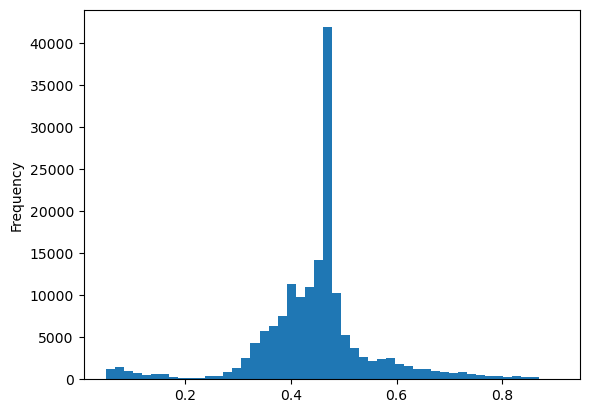

In [20]:
%%time
# development validation
y_pred = clf.predict(X_dev.toarray())
y_pred_proba = clf.predict_proba(X_dev.toarray())

print("Dev")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred
prediction[1].plot.hist(bins=50)

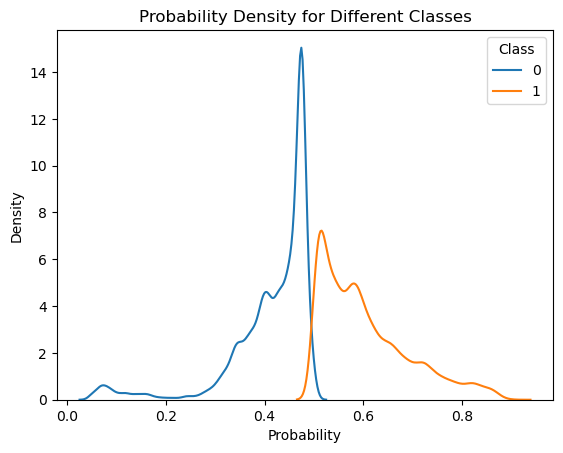

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_dev

# Iterate over each class and plot its density curve
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label)

plt.title('Probability Density for Different Classes')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend(title='Class')
plt.show()

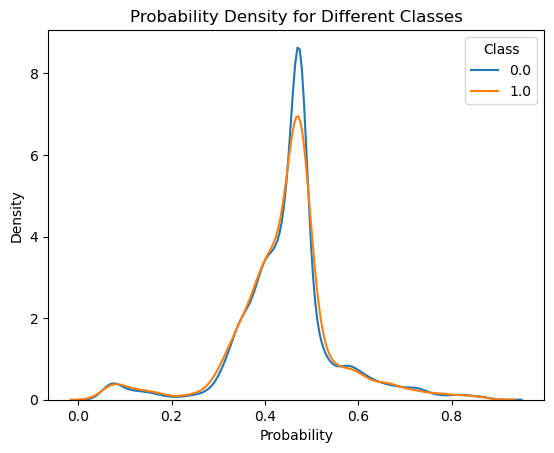

In [22]:
# Iterate over each class and plot its density curve
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label)

plt.title('Probability Density for Different Classes')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend(title='Class')
plt.show()

### Multinomial Naive Bayes  smaller batch size (this is somewhat better)

In [12]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

# traning Gaussian Naive Bayes
clf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1,
                             min_samples_split=100, min_samples_leaf=50, max_features='sqrt')

# The partial fit if you ran out of RAM
batch_size = 1000
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    clf.fit(batch_X.A, batch_y)

100%|██████████████████████████████████████████████████████████████████████████████| 1367/1367 [11:41<00:00,  1.95it/s]


In [13]:
# Define batch size and number of batches
batch_size = 100
n_batches = X_train_res.shape[0] // batch_size

# Initialize lists to hold batch predictions
y_pred = []
y_pred_proba = []

# Iterate over each batch
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]

    # Predict on the batch and append to list
    batch_pred = clf.predict(batch_X.A)
    batch_pred_proba = clf.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Handling the remaining data
if X_train_res.shape[0] % batch_size != 0:
    start = n_batches * batch_size
    batch_X = X_train_res[start:]

    batch_pred = clf.predict(batch_X.A)
    batch_pred_proba = clf.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train_res, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_res, y_pred))
print("average_precision_score",average_precision_score(y_train_res, y_pred))
print(classification_report(y_train_res, y_pred))

100%|████████████████████████████████████████████████████████████████████████████| 13677/13677 [23:32<00:00,  9.68it/s]


Train
accuracy_score 0.5
balanced_accuracy_score 0.5
average_precision_score 0.5


C:\Users\JYM\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\JYM\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67    683885
           1       0.00      0.00      0.00    683885

    accuracy                           0.50   1367770
   macro avg       0.25      0.50      0.33   1367770
weighted avg       0.25      0.50      0.33   1367770



C:\Users\JYM\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dev
accuracy_score 0.8235595344241753
balanced_accuracy_score 0.5
average_precision_score 0.17644046557582477
              precision    recall  f1-score   support

           0       0.82      1.00      0.90    136701
           1       0.00      0.00      0.00     29287

    accuracy                           0.82    165988
   macro avg       0.41      0.50      0.45    165988
weighted avg       0.68      0.82      0.74    165988

Prediction [(0, 165988)]
Ground Truth [(0, 136701), (1, 29287)]


C:\Users\JYM\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\JYM\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\JYM\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Wall time: 18.1 s


<AxesSubplot:ylabel='Frequency'>

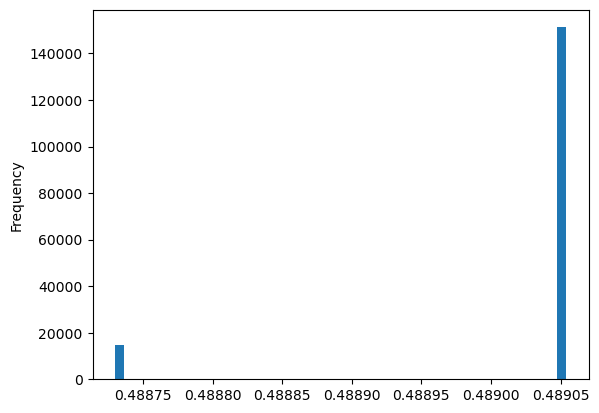

In [14]:
%%time
# development validation
y_pred = clf.predict(X_dev.toarray())
y_pred_proba = clf.predict_proba(X_dev.toarray())

print("Dev")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred
prediction[1].plot.hist(bins=50)

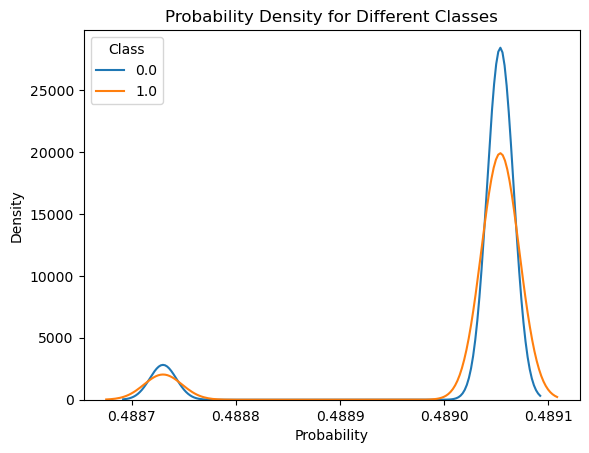

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_dev

# Iterate over each class and plot its density curve
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label)

plt.title('Probability Density for Different Classes')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend(title='Class')
plt.show()

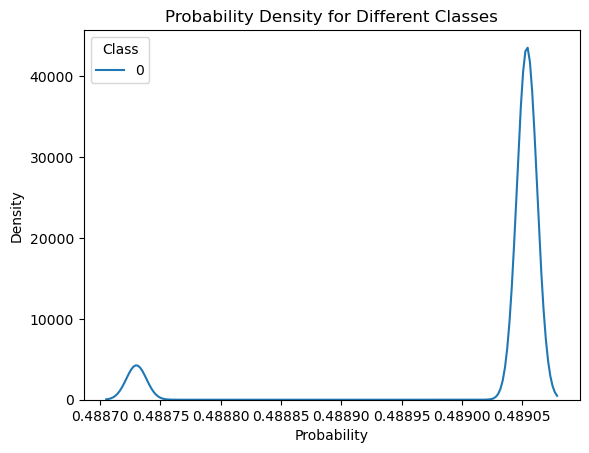

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Iterate over each class and plot its density curve
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label)

plt.title('Probability Density for Different Classes')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend(title='Class')
plt.show()


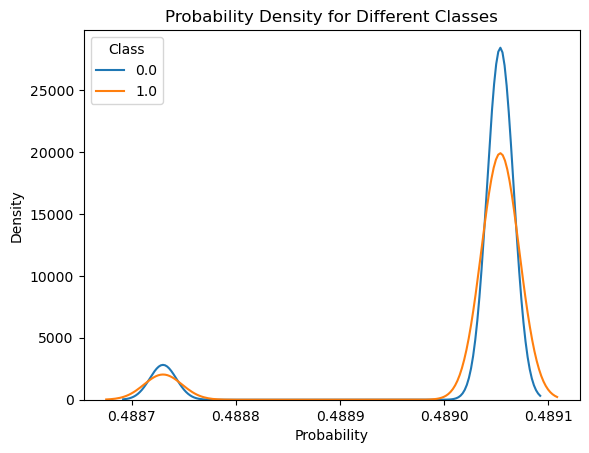

In [17]:
# Iterate over each class and plot its density curve
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label)

plt.title('Probability Density for Different Classes')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend(title='Class')
plt.show()
